<table border="1" width="99%">
  <tr>
    <td bgcolor="#48a259">
      <h1 style="color: #FFFFFF; text-align: center;">Predecir nivel de gravedad</h1>
    </td>
  </tr>
</table>

<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Imports y configuración general</h2>
    </td>
  </tr>
</table>

In [ ]:
import numpy as np
import pandas as pd

# Visualización (opcional)
import matplotlib.pyplot as plt

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Para búsqueda de hiperparámetros
from sklearn.model_selection import RandomizedSearchCV

# Para guardar el modelo entrenado (opcional)
import joblib

# Configuración estética
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

RANDOM_STATE = 42  # Semilla para reproducibilidad


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Carga de datos</h2>
    </td>
  </tr>
</table>

In [ ]:


# Ajusta las rutas si tus archivos están en otra carpeta

fact = pd.read_csv("../Fact/fact_siniestros.csv")

dim_tiempo = pd.read_csv("../Dimensiones/dim_tiempo.csv")
dim_ubigeo = pd.read_csv("../Dimensiones/dim_ubigeo.csv")
dim_tipo = pd.read_csv("../Dimensiones/dim_tipo_siniestro.csv")
dim_causa = pd.read_csv("../Dimensiones/dim_causa_siniestro.csv")
dim_infra = pd.read_csv("../Dimensiones/dim_infraestructura_vial.csv")


In [3]:
print("Tamaños de las tablas:")
print("fact:", fact.shape)
print("dim_tiempo:", dim_tiempo.shape)
print("dim_ubigeo:", dim_ubigeo.shape)
print("dim_tipo:", dim_tipo.shape)
print("dim_causa:", dim_causa.shape)
print("dim_infra:", dim_infra.shape)

Tamaños de las tablas:
fact: (53626, 14)
dim_tiempo: (6548, 11)
dim_ubigeo: (1874, 13)
dim_tipo: (11, 2)
dim_causa: (43, 4)
dim_infra: (352, 8)


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Inspección rápida de la tabla de hechos</h2>
    </td>
  </tr>
</table>

In [ ]:
display(fact.head())
fact.info()
fact.describe(include="all").T.head(20)


,cod_siniestro,fk_tiempo,fk_ubigeo,fk_tipo_siniestro,fk_causa_siniestro,fk_infraestructura,num_fallecidos,num_lesionados,num_vehiculos,zona,red_vial,condicion_climatica,zonificacion,id_fact_siniestro
0,A-2021-01-22,20210101174500,1789,10,42,136,1,1,2.0,URBANA,URBANO,LLUVIOSO,COMERCIAL,1
1,A-2021-01-22,20210101174500,1789,10,36,136,1,1,2.0,URBANA,URBANO,LLUVIOSO,COMERCIAL,2
2,A-2021-01-22,20210101174500,1789,10,33,136,1,1,2.0,URBANA,URBANO,LLUVIOSO,COMERCIAL,3
3,A-2021-01-22,20210101174500,1789,10,32,136,1,1,2.0,URBANA,URBANO,LLUVIOSO,COMERCIAL,4
4,A-2021-01-22,20210101174500,1789,10,31,136,1,1,2.0,URBANA,URBANO,LLUVIOSO,COMERCIAL,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53626 entries, 0 to 53625
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cod_siniestro        53626 non-null  object 
 1   fk_tiempo            53626 non-null  int64  
 2   fk_ubigeo            53626 non-null  int64  
 3   fk_tipo_siniestro    53626 non-null  int64  
 4   fk_causa_siniestro   53626 non-null  int64  
 5   fk_infraestructura   53626 non-null  int64  
 6   num_fallecidos       53626 non-null  int64  
 7   num_lesionados       53626 non-null  int64  
 8   num_vehiculos        43699 non-null  float64
 9   zona                 53557 non-null  object 
 10  red_vial             53626 non-null  object 
 11  condicion_climatica  53313 non-null  object 
 12  zonificacion         53313 non-null  object 
 13  id_fact_siniestro    53626 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.7+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cod_siniestro,53626,6718,A-2022-03-250,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fk_tiempo,53626.0,NaN,NaN,NaN,20219537968783.960938,8027564784.302418,20210101044000.0,20210807123000.0,20220512111500.0,20230126124000.0,20231231212500.0
fk_ubigeo,53626.0,NaN,NaN,NaN,1169.292657,467.927488,1.0,763.0,1220.0,1630.0,1872.0
fk_tipo_siniestro,53626.0,NaN,NaN,NaN,8.244154,2.529425,1.0,7.0,9.0,10.0,11.0
fk_causa_siniestro,53626.0,NaN,NaN,NaN,21.797337,11.149677,1.0,11.0,22.0,31.0,45.0
fk_infraestructura,53626.0,NaN,NaN,NaN,115.170402,113.472054,1.0,1.0,81.0,208.0,352.0
num_fallecidos,53626.0,NaN,NaN,NaN,1.225693,1.099162,1.0,1.0,1.0,1.0,33.0
num_lesionados,53626.0,NaN,NaN,NaN,0.972774,2.788803,0.0,0.0,0.0,1.0,71.0
num_vehiculos,43699.0,NaN,NaN,NaN,1.375363,0.709803,0.0,1.0,1.0,2.0,15.0
zona,53557,2,RURAL,34108,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Creación de la variable objetivo "gravedad"</h2>
    </td>
  </tr>
</table>

In [ ]:
# Verificamos primero la distribución original de num_fallecidos
print(fact["num_fallecidos"].describe())
print(fact["num_fallecidos"].value_counts().sort_index())

# Función para clasificar gravedad
def clasificar_gravedad(n_falle):
    """
    Traduce el número de fallecidos en una categoría de gravedad.
    Ajusta los umbrales si tu lógica de negocio es diferente.
    """
    if pd.isna(n_falle):
        return np.nan
    n = int(n_falle)
    if n == 1:
        return "leve"
    elif 2 <= n <= 3:
        return "moderado"
    else:
        return "grave"

fact["gravedad"] = fact["num_fallecidos"].apply(clasificar_gravedad)

print("\nDistribución de la gravedad:")
print(fact["gravedad"].value_counts(dropna=False))


count    53626.000000
mean         1.225693
std          1.099162
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: num_fallecidos, dtype: float64
num_fallecidos
1     47143
2      4297
3      1297
4       402
5       169
6       104
7        39
8        36
9         1
10        1
11       36
12        1
13       19
16       18
17        1
18       18
20       18
24        1
26        7
33       18
Name: count, dtype: int64

Distribución de la gravedad:
gravedad
leve        47143
moderado     5594
grave         889
Name: count, dtype: int64


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Construcción del dataframe para el modelo
</h2>
    </td>
  </tr>
</table>

In [ ]:
# Unimos dimensiones básicas con la fact
df_modelo = fact.merge(
    dim_tiempo[["pk_tiempo", "anio", "mes", "dia_semana", "trimestre"]],
    left_on="fk_tiempo", right_on="pk_tiempo", how="left"
).merge(
    dim_ubigeo[["id_ubigeo", "departamento", "region_natural", "habitantes"]],
    left_on="fk_ubigeo", right_on="id_ubigeo", how="left"
).merge(
    dim_tipo[["id_tipo_siniestro", "clase_siniestro"]],
    left_on="fk_tipo_siniestro", right_on="id_tipo_siniestro", how="left"
).merge(
    dim_causa[["id_causa", "categoria_causa"]],
    left_on="fk_causa_siniestro", right_on="id_causa", how="left"
).merge(
    dim_infra[["id_infraestructura", "existe_ciclovia", "perfil_via", "caracteristicas_via"]],
    left_on="fk_infraestructura", right_on="id_infraestructura", how="left"
)

print(df_modelo.shape)
df_modelo.head()


(53626, 32)


,cod_siniestro,fk_tiempo,fk_ubigeo,fk_tipo_siniestro,fk_causa_siniestro,fk_infraestructura,num_fallecidos,num_lesionados,num_vehiculos,zona,...,region_natural,habitantes,id_tipo_siniestro,clase_siniestro,id_causa,categoria_causa,id_infraestructura,existe_ciclovia,perfil_via,caracteristicas_via
0,A-2021-01-22,20210101174500,1789,10,42,136,1,1,2.0,URBANA,...,SELVA ALTA,27203,10,Choque,42,No identificado,136,NO,PLANA,INTERSECCIÓN
1,A-2021-01-22,20210101174500,1789,10,36,136,1,1,2.0,URBANA,...,SELVA ALTA,27203,10,Choque,36,Velocidad / Conducción temeraria,136,NO,PLANA,INTERSECCIÓN
2,A-2021-01-22,20210101174500,1789,10,33,136,1,1,2.0,URBANA,...,SELVA ALTA,27203,10,Choque,33,Maniobras indebidas,136,NO,PLANA,INTERSECCIÓN
3,A-2021-01-22,20210101174500,1789,10,32,136,1,1,2.0,URBANA,...,SELVA ALTA,27203,10,Choque,32,Desacato a señalización,136,NO,PLANA,INTERSECCIÓN
4,A-2021-01-22,20210101174500,1789,10,31,136,1,1,2.0,URBANA,...,SELVA ALTA,27203,10,Choque,31,Maniobras indebidas,136,NO,PLANA,INTERSECCIÓN


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Selección de features y limpieza básica</h2>
    </td>
  </tr>
</table>

In [ ]:
# Eliminamos filas sin etiqueta de gravedad (por si hay nulos en num_fallecidos)
df_modelo = df_modelo.dropna(subset=["gravedad"]).copy()

# Definimos la variable objetivo
y = df_modelo["gravedad"]

# Lista de features (ajusta según las columnas que tengas)
feature_cols = [
    "num_lesionados",
    "num_vehiculos",
    "anio",
    "mes",
    "habitantes",
    "zona",                # desde fact_siniestros
    "red_vial",            # desde fact_siniestros
    "condicion_climatica", # desde fact_siniestros
    "zonificacion",        # desde fact_siniestros
    "departamento",
    "region_natural",
    "clase_siniestro",
    "categoria_causa",
    "existe_ciclovia",
    "perfil_via",
    "caracteristicas_via",
]

# Nos quedamos solo con esas columnas (las que existan)
feature_cols_validas = [c for c in feature_cols if c in df_modelo.columns]
X = df_modelo[feature_cols_validas].copy()

print("Columnas usadas como features:")
print(feature_cols_validas)

X.head()


Columnas usadas como features:
['num_lesionados', 'num_vehiculos', 'anio', 'mes', 'habitantes', 'zona', 'red_vial', 'condicion_climatica', 'zonificacion', 'departamento', 'region_natural', 'clase_siniestro', 'categoria_causa', 'existe_ciclovia', 'perfil_via', 'caracteristicas_via']


,num_lesionados,num_vehiculos,anio,mes,habitantes,zona,red_vial,condicion_climatica,zonificacion,departamento,region_natural,clase_siniestro,categoria_causa,existe_ciclovia,perfil_via,caracteristicas_via
0,1,2.0,2021,1,27203,URBANA,URBANO,LLUVIOSO,COMERCIAL,SAN MARTIN,SELVA ALTA,Choque,No identificado,NO,PLANA,INTERSECCIÓN
1,1,2.0,2021,1,27203,URBANA,URBANO,LLUVIOSO,COMERCIAL,SAN MARTIN,SELVA ALTA,Choque,Velocidad / Conducción temeraria,NO,PLANA,INTERSECCIÓN
2,1,2.0,2021,1,27203,URBANA,URBANO,LLUVIOSO,COMERCIAL,SAN MARTIN,SELVA ALTA,Choque,Maniobras indebidas,NO,PLANA,INTERSECCIÓN
3,1,2.0,2021,1,27203,URBANA,URBANO,LLUVIOSO,COMERCIAL,SAN MARTIN,SELVA ALTA,Choque,Desacato a señalización,NO,PLANA,INTERSECCIÓN
4,1,2.0,2021,1,27203,URBANA,URBANO,LLUVIOSO,COMERCIAL,SAN MARTIN,SELVA ALTA,Choque,Maniobras indebidas,NO,PLANA,INTERSECCIÓN


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Identificar variables numéricas y categóricas
</h2>
    </td>
  </tr>
</table>

In [ ]:
# Consideramos numéricas las de tipo int o float
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# El resto serán categóricas
categorical_features = [c for c in X.columns if c not in numeric_features]

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)


Numéricas: ['num_lesionados', 'num_vehiculos', 'anio', 'mes', 'habitantes']
Categóricas: ['zona', 'red_vial', 'condicion_climatica', 'zonificacion', 'departamento', 'region_natural', 'clase_siniestro', 'categoria_causa', 'existe_ciclovia', 'perfil_via', 'caracteristicas_via']


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Definición de transformadores de preprocesamiento</h2>
    </td>
  </tr>
</table>

In [ ]:
from sklearn.pipeline import make_pipeline

# Para numéricas: imputamos con mediana y escalamos
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Para categóricas: imputamos con moda y codificamos one-hot
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# ColumnTransformer aplica un pipeline distinto a numéricas y categóricas
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['num_lesionados', 'num_vehiculos', 'anio',
                                  'mes', 'habitantes']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['zona', 'red_vial', 'condicion_climatica',
                                  'zonificacion', 'departamento',
                                  'region_natural', 'clase_siniestro',
                                  'categoria_causa', 'existe_ciclovia',
                                  'perfil_via', 'caracteristicas_via'])])

<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Pipeline completo (preprocesamiento + modelo base)</h2>
    </td>
  </tr>
</table>

In [ ]:
model_base = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    class_weight="balanced",  # importante por el desbalance de clases
    random_state=RANDOM_STATE,
)

clf_base = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model_base),
])

clf_base


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['num_lesionados',
                                                   'num_vehiculos', 'anio',
                                                   'mes', 'habitantes']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['zona', 'red_vial',
                                                   'condicion_climatica',
                                                   'zonificacion',
                                                   'departamento',
                                                   'region_natural',
                                                   'clase_siniestro',
                                                   'categoria_causa',
                                                   'existe_ciclovia',
                                                   'perfil_via',
                                                   'caracteristicas_via'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, n_jobs=-1,
                                        random_state=42))])

<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Separación train/test y entrenamiento del modelo base</h2>
    </td>
  </tr>
</table>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,            # estratificado por gravedad para mantener proporciones
    random_state=RANDOM_STATE
)

print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño test:", X_test.shape)

# Entrenamos el modelo base
clf_base.fit(X_train, y_train)

# Predicciones en test
y_pred_base = clf_base.predict(X_test)

print("\nReporte de clasificación - Modelo base:")
print(classification_report(y_test, y_pred_base))


Tamaño entrenamiento: (42900, 16)
Tamaño test: (10726, 16)

Reporte de clasificación - Modelo base:
              precision    recall  f1-score   support

       grave       0.99      0.96      0.98       178
        leve       0.99      1.00      0.99      9429
    moderado       0.99      0.92      0.95      1119

    accuracy                           0.99     10726
   macro avg       0.99      0.96      0.97     10726
weighted avg       0.99      0.99      0.99     10726



<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Matriz de confusión</h2>
    </td>
  </tr>
</table>

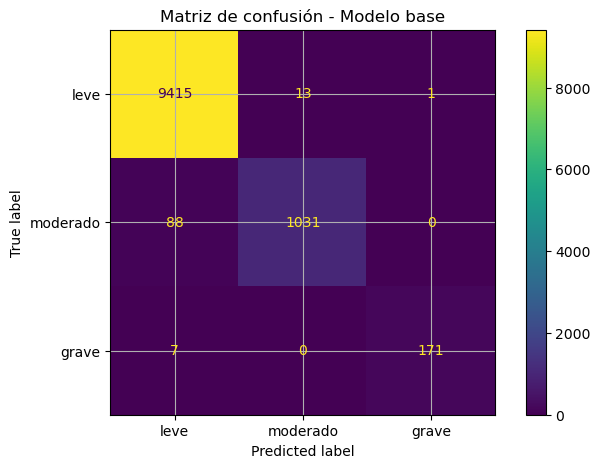

In [ ]:
cm = confusion_matrix(y_test, y_pred_base, labels=["leve", "moderado", "grave"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["leve", "moderado", "grave"])
disp.plot()
plt.title("Matriz de confusión - Modelo base")
plt.show()


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Validación cruzada (StratifiedKFold)</h2>
    </td>
  </tr>
</table>

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scores = cross_val_score(
    clf_base,
    X, y,
    cv=cv,
    scoring="f1_macro",   # F1 promedio entre clases
    n_jobs=-1
)

print("Scores F1-macro en CV:", scores)
print("F1-macro promedio:", scores.mean())
print("Desviación estándar:", scores.std())


Scores F1-macro en CV: [0.97813477 0.97655604 0.97229239 0.96953973 0.97124954]
F1-macro promedio: 0.9735544929623277
Desviación estándar: 0.003256140789455796


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Búsqueda de hiperparámetros con RandomizedSearchCV</h2>
    </td>
  </tr>
</table>

In [ ]:
param_distributions = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [None, 5, 10, 20, 30],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__max_features": ["sqrt", "log2", 0.5, 0.7],
}

clf_rs = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_jobs=-1,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )),
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

search = RandomizedSearchCV(
    clf_rs,
    param_distributions=param_distributions,
    n_iter=20,                # número de combinaciones a probar
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=RANDOM_STATE,
)

search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(search.best_params_)
print("\nMejor score F1-macro (CV):", search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros encontrados:
{'model__n_estimators': 300, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 0.5, 'model__max_depth': None}

Mejor score F1-macro (CV): 0.9759699801279941


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Evaluación del mejor modelo en el test</h2>
    </td>
  </tr>
</table>

Reporte de clasificación - Mejor modelo:
              precision    recall  f1-score   support

       grave       0.97      0.97      0.97       178
        leve       0.99      1.00      1.00      9429
    moderado       0.98      0.95      0.96      1119

    accuracy                           0.99     10726
   macro avg       0.98      0.97      0.98     10726
weighted avg       0.99      0.99      0.99     10726



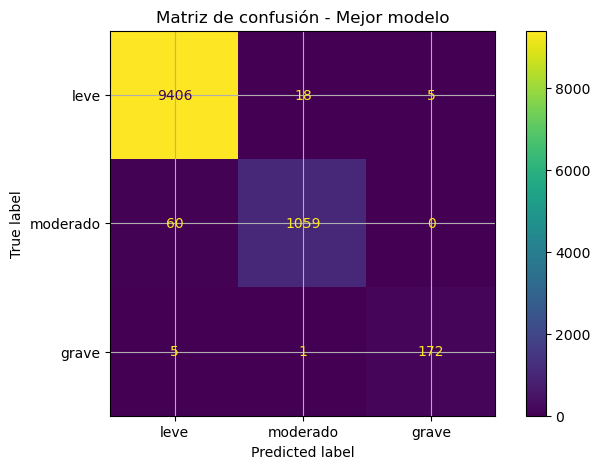

In [ ]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test)

print("Reporte de clasificación - Mejor modelo:")
print(classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best, labels=["leve", "moderado", "grave"])
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=["leve", "moderado", "grave"])
disp_best.plot()
plt.title("Matriz de confusión - Mejor modelo")
plt.show()


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Importancias de variables</h2>
    </td>
  </tr>
</table>

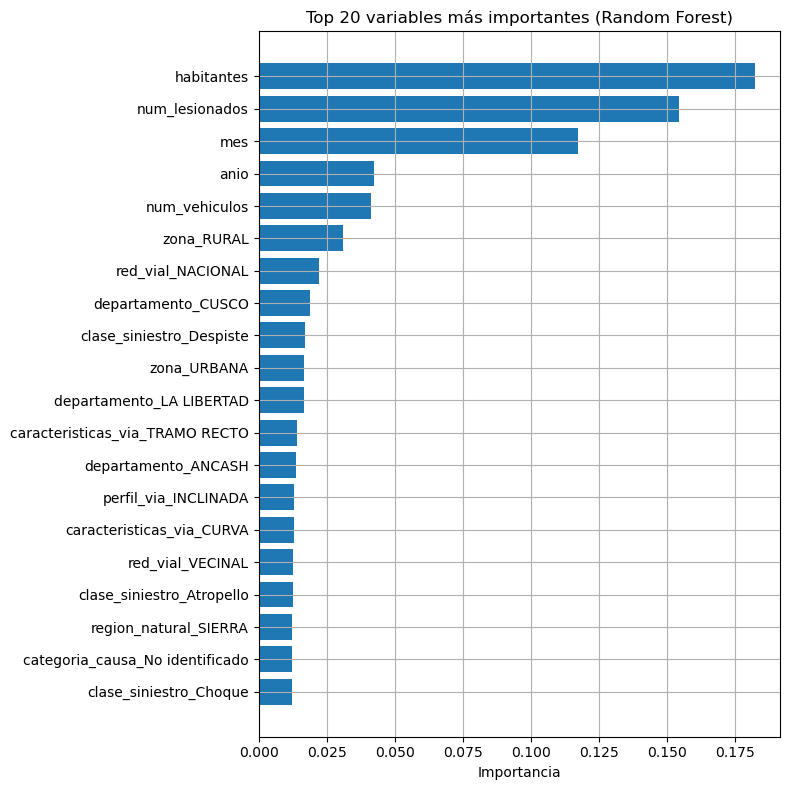

In [ ]:
# Obtenemos el modelo RandomForest interno
rf = best_model.named_steps["model"]

# Obtenemos nombres de todas las columnas después del preprocesamiento
# 1) Nombres numéricos (tal cual)
num_feature_names = numeric_features

# 2) Nombres categóricos expandidos por OneHotEncoder
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehotencoder"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

importances = rf.feature_importances_

# Top 20 features más importantes
idx = np.argsort(importances)[::-1][:20]
top_features = all_feature_names[idx]
top_importances = importances[idx]

plt.figure(figsize=(8, 8))
plt.barh(range(len(top_features)), top_importances[::-1])
plt.yticks(range(len(top_features)), top_features[::-1])
plt.xlabel("Importancia")
plt.title("Top 20 variables más importantes (Random Forest)")
plt.tight_layout()
plt.show()


<table width="99%">
  <tr>
    <td bgcolor="#FFBA39">
      <h2 style="color: #000000; text-align: left;">Guardar el modelo a disco (opcional)</h2>
    </td>
  </tr>
</table>

In [ ]:
joblib.dump(best_model, "modelo_gravedad_siniestros.joblib")

print("Modelo guardado como 'modelo_gravedad_siniestros.joblib'")


Modelo guardado como 'modelo_gravedad_siniestros.joblib'
